# Passive Aggressive Classifier Model

With instagram posts as train and test sets.

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import requests
import json
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
import collections

In [3]:
# Load dataset 
df = pd.read_csv('main_df2.csv')


In [6]:
len(df)

8415

In [5]:
df.dropna(subset=['preprocessed_caption'], inplace=True)

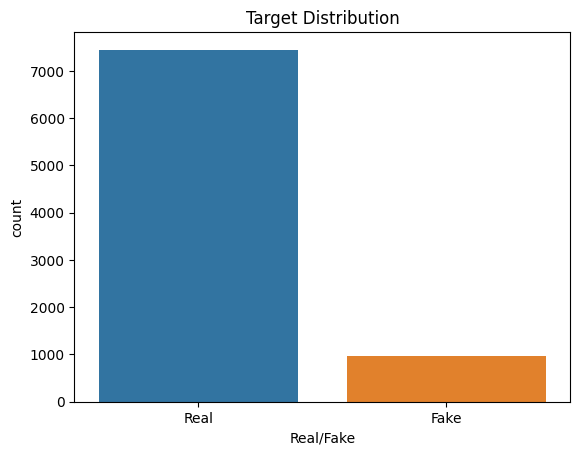

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_fake', data=df)
plt.title('Target Distribution')
plt.xlabel('Real/Fake')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()


In [12]:
df.groupby("is_fake").count()

,Unnamed: 0,level_0,index,Unnamed: 0.1,id,permalink,comments_count,like_count,media_type,media_url,timestamp,caption,actual_text,hashtags,is_english,english_caption,preprocessed_caption
is_fake,,,,,,,,,,,,,,,,,
0,5483,5483,5483,5483,5483,5483,5483,5180,5483,4387,5483,5483,5483,5358,5483,5483,5483
1,613,613,613,613,613,613,613,593,613,452,613,613,613,547,613,613,613


In [65]:
fake_preprocessed_caption = df[df['is_fake'] == 0]['preprocessed_caption'].tolist()
real_preprocessed_caption = df[df['is_fake'] == 1]['preprocessed_caption'].tolist()


Text(0.5, 1.0, 'Most common words in Title for Real News')

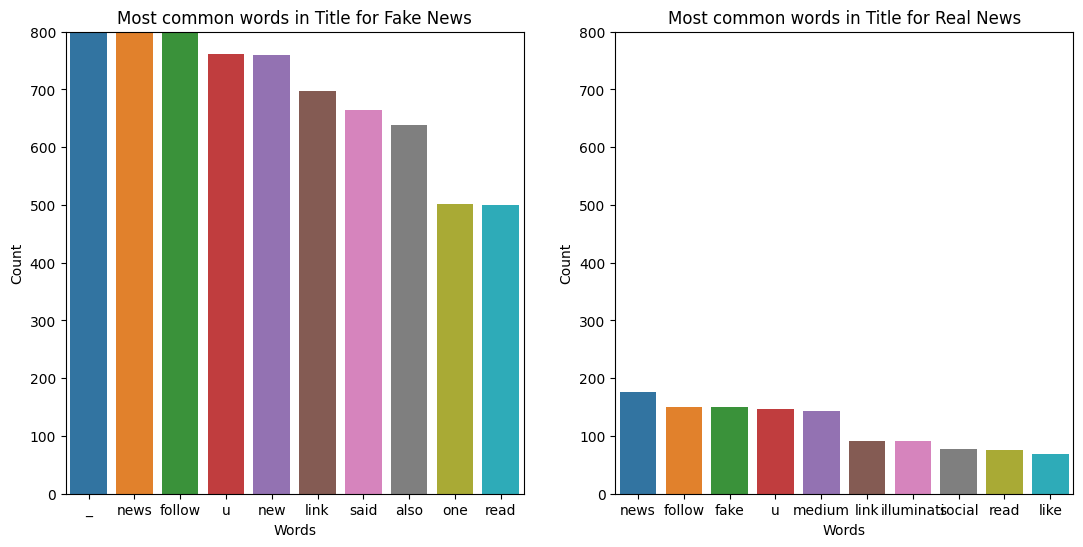

In [66]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

# Convert the lists to string format
fake_preprocessed_caption = [str(caption) for caption in fake_preprocessed_caption]
real_preprocessed_caption = [str(caption) for caption in real_preprocessed_caption]

# Calculate word count
fake0_wrd = get_wrd_count(fake_preprocessed_caption)
real1_wrd = get_wrd_count(real_preprocessed_caption)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)

l0, h0, l1, h1 = [], [], [], []
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0])
ax[0].set_ylim(top=800)
ax[0].set_xticks(ticks=list(range(len(l0))))
ax[0].set_xticklabels(l0)
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Count')
ax[0].set_title("Most common words in Title for Fake News")

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1])
ax[1].set_ylim(top=800)
ax[1].set_xticks(ticks=list(range(len(l1))))
ax[1].set_xticklabels(l1)
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Count')
ax[1].set_title("Most common words in Title for Real News")


In [13]:
#Drop very short captions 
df.drop(df[(df['preprocessed_caption'].str.len() < 45) & (df['is_fake']==0)].index, inplace=True)
df.drop(df[(df['preprocessed_caption'].str.len() < 45) & (df['is_fake']==1)].index, inplace=True)

In [16]:
# Sampling real posts to even up the number of fake and real
X_r=df[(df['preprocessed_caption'].str.len() >100) & (df['is_fake']==0)].sample(n=1000,random_state=42)[['preprocessed_caption','is_fake']]
X_f=df[(df['is_fake']==1)][['preprocessed_caption','is_fake']]
joined_df = X_r.append(X_f, ignore_index=False)
#Randomizing the entries
randomized_df = joined_df.sample(frac=1, random_state=42)
labels= randomized_df['is_fake']

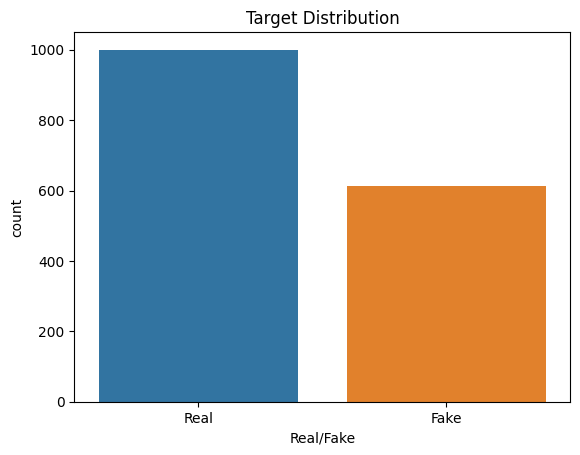

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_fake', data=joined_df)
plt.title('Target Distribution')
plt.xlabel('Real/Fake')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()


Test size of 15%

In [18]:
x_train, x_test, y_train, y_test = train_test_split( randomized_df['preprocessed_caption'] ,labels, test_size=0.15, random_state=42)

In [20]:
#TF-IDF considers how often the word appears in the entire corpus and assigns a weight 
#to each word based on how important it is in the document.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)

In [21]:

tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In [22]:
# Modified perceptron that avoids misclassifications
pac = PassiveAggressiveClassifier( max_iter = 50)
pac.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [23]:
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print( 'Model Accuracy :', round(score*100,2) )

Model Accuracy : 86.78


In [24]:
results_df= pd.DataFrame(y_test)
results_df['y_test']=""
results_df['y_test']=results_df['is_fake']
results_df.drop(columns="is_fake", inplace=True)
results_df['y_pred']=y_pred

results_df = results_df.merge(df, left_index=True, right_index=True, how='inner')


In [25]:
results_df[['y_test', 'y_pred', 'is_fake',
       'id', 'permalink', 'comments_count', 'like_count', 'media_type',
       'media_url', 'actual_text']]

,y_test,y_pred,is_fake,id,permalink,comments_count,like_count,media_type,media_url,actual_text
3315,0,0,0,17972937086190563,https://www.instagram.com/p/CtUhETDJyXq/,0.0,2.0,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,Ukrainian President Volodymyr Zelenskyy said S...
4736,0,0,0,18371869510028165,https://www.instagram.com/p/CtUDIjUJMhC/,1.0,60.0,IMAGE,https://scontent-iad3-1.cdninstagram.com/v/t51...,A huge mural of soccer superstar Lionel Messi ...
8123,1,0,1,18351512836065423,https://www.instagram.com/p/CrjAoquN-sI/,8.0,501.0,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,"Well, well. That’s, um, two wells. This is the..."
603,0,0,0,18191720557264311,https://www.instagram.com/p/CtWAsY0stBT/,0.0,NaN,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,A recent study has revealed that population co...
7938,1,1,1,17904173387789777,https://www.instagram.com/p/Cs4LSCIvWXa/,131.0,23699.0,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,Felix got cucked by his girlfriend more times ...
...,...,...,...,...,...,...,...,...,...,...
485,0,0,0,17996002681938297,https://www.instagram.com/reel/CtWDIjzNnRO/,1.0,145.0,VIDEO,https://scontent-iad3-1.cdninstagram.com/o1/v/...,Interior Ministry said it arrested a man who a...
4959,0,0,0,18019689268602854,https://www.instagram.com/p/CtT_JTwoK4V/,1.0,16.0,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,Interest from Championship and Premier League?...
5814,0,0,0,18070168453383159,https://www.instagram.com/p/Ct1NDzBsWjt/,0.0,5.0,CAROUSEL_ALBUM,NaN,Happy Friday! Here is your Rex Music News. You...
3853,0,0,0,17844370053000519,https://www.instagram.com/p/CtUUlzPMfxi/,0.0,0.0,IMAGE,https://scontent-iad3-2.cdninstagram.com/v/t51...,"Jack Grealish’s wild love life – Emily Atack, ..."


In [ ]:
confusion_matrix(y_test, y_pred, labels=labels.unique())

array([[140,   6],
       [ 27,  69]])

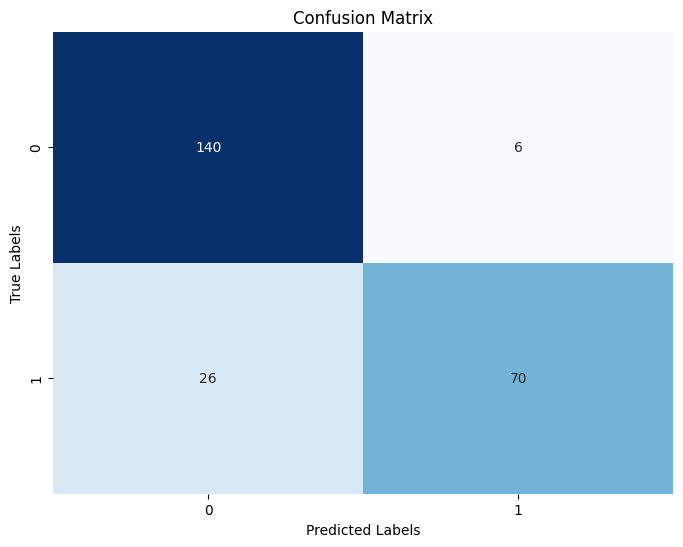

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(results_df['y_test'], results_df['y_pred'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Selecting true positive instances
true_positive_df = results_df[(results_df['y_test'] == 1) & (results_df['y_test'] == results_df['y_pred'])]



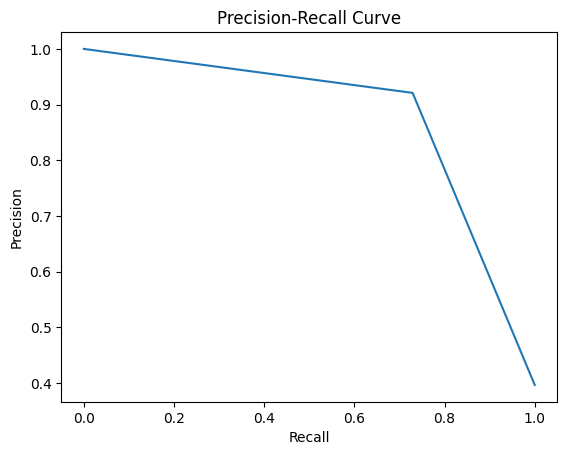

In [27]:
precision, recall, thresholds = precision_recall_curve(results_df['y_test'], results_df['y_pred'])

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [29]:
def FactCheck(query):
    payload = {
    'key': 'ENTER_API_KEY',
    'query':query
    }
    url ='https://factchecktools.googleapis.com/v1alpha1/claims:search'
    response = requests.get(url,params=payload)
    print(response)
    if response.status_code == 200:
        result = json.loads(response.text)
        # Arbitrarily select 1
        try:
            topRating = result["claims"][0]
            # arbitrarily select top 1
            claimReview = topRating["claimReview"][0]["textualRating"]
            claimVal = "According to " + str(topRating["claimReview"][0]['publisher']['name'])+ " that claim is " + str(claimReview)
            print(result)
            return claimVal           
        except Exception as e:
            print("No claim review field found.")
            print(e)
            return 0
    else:
        return 0

In [41]:
results_df['fact_check']=""

In [39]:
results_df.reset_index(drop=True,inplace=True)

In [44]:
for row in range(len(results_df)):
    results_df['fact_check'][row]=FactCheck(results_df['english_caption'][row])

<Response [200]>
No claim review field found.
'claims'
/tmp/ipykernel_141/765899416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['fact_check'][row]=FactCheck(results_df['english_caption'][row])
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'claims'
<Response [200]>
No claim review field found.
'clai

The following results show an example of a correctly guessed fake post which is also detected by Google's fact checker:

In [49]:
results_df.groupby("fact_check").count()

,y_test,y_pred,Unnamed: 0,level_0,index,Unnamed: 0.1,id,permalink,comments_count,like_count,media_type,media_url,timestamp,caption,is_fake,actual_text,hashtags,is_english,english_caption,preprocessed_caption
fact_check,,,,,,,,,,,,,,,,,,,,
0,241,241,241,241,241,241,241,241,241,229,241,184,241,241,241,241,227,241,241,241
According to The Quint that claim is False,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [53]:
results_df[results_df["fact_check"]!=0]

,y_test,y_pred,Unnamed: 0,level_0,index,Unnamed: 0.1,id,permalink,comments_count,like_count,...,media_url,timestamp,caption,is_fake,actual_text,hashtags,is_english,english_caption,preprocessed_caption,fact_check
147,1,1,8408,132285,2275,2275,17987897854806990,https://www.instagram.com/p/CpFVCJJpx3e/,38.0,2029.0,...,https://scontent-iad3-1.cdninstagram.com/v/t51...,2023-02-25T11:12:38+0000,#WebQoof | An edited video of Bollywood actor ...,1,| An edited video of Bollywood actor with her ...,#WebQoof #AishwaryaRaiBachchan #FactCheck #Mis...,1,An edited video of Bollywood actor with her d...,"edited video bollywood actor daughter , aaradh...",According to The Quint that claim is False


In [67]:
results_df

,y_test,y_pred,Unnamed: 0,level_0,index,Unnamed: 0.1,id,permalink,comments_count,like_count,...,media_url,timestamp,caption,is_fake,actual_text,hashtags,is_english,english_caption,preprocessed_caption,fact_check
0,0,0,3315,8920,8920,8920,17972937086190563,https://www.instagram.com/p/CtUhETDJyXq/,0.0,2.0,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-06-10T18:51:58+0000,Ukrainian President Volodymyr Zelenskyy said S...,0,Ukrainian President Volodymyr Zelenskyy said S...,#Ukraine #VolodymyrZelenskyy #counteroffensive...,1,Ukrainian President Volodymyr Zelenskyy said ...,ukrainian president volodymyr zelenskyy said s...,0
1,0,0,4736,12852,12852,12852,18371869510028165,https://www.instagram.com/p/CtUDIjUJMhC/,1.0,60.0,...,https://scontent-iad3-1.cdninstagram.com/v/t51...,2023-06-10T14:30:24+0000,A huge mural of soccer superstar Lionel Messi ...,0,A huge mural of soccer superstar Lionel Messi ...,#Argentina #LionelMessi #FIFA #fifaworldcup202...,1,A huge mural of soccer superstar Lionel Messi...,huge mural soccer superstar lionel messi seen ...,0
2,1,0,8123,130941,931,931,18351512836065423,https://www.instagram.com/p/CrjAoquN-sI/,8.0,501.0,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-04-27T16:54:23+0000,"Well, well. That’s, um, two wells. This is the...",1,"Well, well. That’s, um, two wells. This is the...",#folk #fantasticfolk #holywell #notsoholy #pre...,1,"Well, um, two This is the second well to be f...","well , um , two second well found holystone , ...",0
3,0,0,603,1734,1734,1734,18191720557264311,https://www.instagram.com/p/CtWAsY0stBT/,0.0,NaN,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-06-11T08:47:33+0000,A recent study has revealed that #Ghana’s popu...,0,A recent study has revealed that population co...,#Ghana’s #Accra #heritagetimes #ht #news,1,A recent study has revealed that population c...,recent study revealed population could double ...,0
4,1,1,7938,130122,112,112,17904173387789777,https://www.instagram.com/p/Cs4LSCIvWXa/,131.0,23699.0,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-05-30T18:42:52+0000,Felix got cucked by his girlfriend more times ...,1,Felix got cucked by his girlfriend more times ...,NaN,1,Felix got cucked by his girlfriend more times...,felix got cucked girlfriend time season goal f...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0,0,485,1427,1427,1427,17996002681938297,https://www.instagram.com/reel/CtWDIjzNnRO/,1.0,145.0,...,https://scontent-iad3-1.cdninstagram.com/o1/v/...,2023-06-11T09:11:52+0000,#Kuwait’s Interior Ministry said it arrested a...,0,Interior Ministry said it arrested a man who a...,#Kuwait’s #KuwaitInside #Latestnews #KuwaitCit...,1,Interior Ministry said it arrested a man who ...,interior ministry said arrested man appeared v...,0
238,0,0,4959,13522,13522,13522,18019689268602854,https://www.instagram.com/p/CtT_JTwoK4V/,1.0,16.0,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-06-10T13:55:33+0000,Interest from Championship and Premier League?...,0,Interest from Championship and Premier League?...,NaN,1,Interest from Championship and Premier Recent...,interest championship premier recently relegat...,0
239,0,0,5814,60359,302,302,18070168453383159,https://www.instagram.com/p/Ct1NDzBsWjt/,0.0,5.0,...,NaN,2023-06-23T11:32:04+0000,Happy Friday! Here is your Rex Music News. You...,0,Happy Friday! Here is your Rex Music News. You...,#friday #musicnews #news #newrelease #newalbum...,1,Happy Here is your Rex Music Your weekly musi...,happy rex music weekly music block party annou...,0
240,0,0,3853,10318,10318,10318,17844370053000519,https://www.instagram.com/p/CtUUlzPMfxi/,0.0,0.0,...,https://scontent-iad3-2.cdninstagram.com/v/t51...,2023-06-10T17:03:00+0000,"Jack Grealish’s wild love life – Emily Atack, ...",0,"Jack Grealish’s wild love life – Emily Atack, ...",#3am #Showbiz #CelebNews #Celebs #DTNNews #Emi...,1,"Jack wild love life Emily Atack, Love Island ...","jack wild lo

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4c8af7b1-f3b8-45ab-bbdc-6a32713107d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>